<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg" />
</center> 
     
## <center>  [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 

#### <center> Author: [Yury Kashnitsky](https://yorko.github.io) (@yorko) 

# <center>Assignment #2. Fall 2019
## <center> Part 2. Gradient boosting

**In this assignment, you're asked to beat a baseline in the ["Flight delays" competition](https://www.kaggle.com/c/flight-delays-fall-2018).**

This time we decided to share a pretty decent CatBoost baseline, you'll have to improve the provided solution.

Prior to working on the assignment, you'd better check out the corresponding course material:
 1. [Classification, Decision Trees and k Nearest Neighbors](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic03_decision_trees_kNN/topic3_decision_trees_kNN.ipynb?flush_cache=true), the same as an interactive web-based [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-3-decision-trees-and-knn) 
 2. Ensembles:
  - [Bagging](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part1_bagging.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-1-bagging)
  - [Random Forest](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part2_random_forest.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-2-random-forest)
  - [Feature Importance](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part3_feature_importance.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-3-feature-importance)
 3. - [Gradient boosting](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic10_boosting/topic10_gradient_boosting.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-10-gradient-boosting) 
   - Logistic regression, Random Forest, and LightGBM in the "Kaggle Forest Cover Type Prediction" competition: [Kernel](https://www.kaggle.com/kashnitsky/topic-10-practice-with-logit-rf-and-lightgbm) 
 4. You can also practice with demo assignments, which are simpler and already shared with solutions:
  - "Decision trees with a toy task and the UCI Adult dataset": [assignment](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees) + [solution](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees-solution)
  - "Logistic Regression and Random Forest in the credit scoring problem": [assignment](https://www.kaggle.com/kashnitsky/assignment-5-logit-and-rf-for-credit-scoring) + [solution](https://www.kaggle.com/kashnitsky/a5-demo-logit-and-rf-for-credit-scoring-sol)
 5. There are also 7 video lectures on trees, forests, boosting and their applications: [mlcourse.ai/video](https://mlcourse.ai/video) 
 6. mlcourse.ai tutorials on [categorical feature encoding](https://www.kaggle.com/waydeherman/tutorial-categorical-encoding) (by Wayde Herman) and [CatBoost](https://www.kaggle.com/mitribunskiy/tutorial-catboost-overview) (by Mikhail Tribunskiy)
 7. Last but not the least: [Public Kernels](https://www.kaggle.com/c/flight-delays-fall-2018/notebooks) in this competition

### Your task is to:
 1. beat **"A2 baseline (10 credits)"** on Public LB (**0.75914** LB score)
 2. rename your [team](https://www.kaggle.com/c/flight-delays-fall-2018/team) in full accordance with A1 and the [course rating](https://docs.google.com/spreadsheets/d/15e1K0tg5ponA5R6YQkZfihrShTDLAKf5qeKaoVCiuhQ/) (to appear on 16.09.2019)
 
This task is intended to be relatively easy. Here you are not required to upload your reproducible solution.
 
### <center> Deadline for A2: 2019 October 6, 20:59 CET (London time)

In [1]:
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from catboost import cv
from catboost import Pool
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

**Read the data**

In [2]:
PATH_TO_DATA = Path('flight-delays-fall-2018/')

In [3]:
train_df = pd.read_csv('flight_delays_train.csv')

In [4]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [5]:
test_df = pd.read_csv('flight_delays_test.csv')

In [6]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


**Create only one feature - “flight” (this you need to improve - add more features)**

In [7]:
train_df['flight'] = train_df['Origin'] + '-->' + train_df['Dest']
test_df['flight'] = test_df['Origin'] + '-->' + test_df['Dest']

In [9]:
train_df.flight.head()

0    ATL-->DFW
1    PIT-->MCO
2    RDU-->CLE
3    DEN-->MEM
4    MDW-->OMA
Name: flight, dtype: object

**Remember indexes of categorical features (to be passed to CatBoost)**

In [8]:
categ_feat_idx = np.where(train_df.drop('dep_delayed_15min', axis=1).dtypes == 'object')[0]
categ_feat_idx

array([0, 1, 2, 4, 5, 6, 8], dtype=int64)

**Allocate a hold-out set to validate the model**

In [15]:
X_train = train_df.drop('dep_delayed_15min', axis=1)
y_train = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test_df

In [157]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, 
                                                                test_size=0.3, 
                                                                random_state=17)

**Train Catboost with default arguments, passing only the indexes of categorical features.**

In [160]:
ctb = CatBoostClassifier(random_seed=17, eval_metric = 'AUC')

In [159]:
# %%time
ctb.fit(X_train_part, y_train_part,
        eval_set=(X_valid, y_valid),
        cat_features=categ_feat_idx,
        early_stopping_rounds = 200,
        verbose = 200,
        use_best_model=True,
       );

Learning rate set to 0.121895
0:	test: 0.6604672	best: 0.6604672 (0)	total: 136ms	remaining: 2m 15s


KeyboardInterrupt: 

In [38]:
ctb_valid_pred = ctb.predict_proba(X_valid)[:, 1]

##### **We got some 0.756 ROC AUC on the hold-out set.**

In [39]:
roc_auc_score(y_valid, ctb_valid_pred)

0.7595054577081344

**Train on the whole train set, make prediction on the test set. We got ~0.734 in the competition - "Catboost starter" baseline**

In [161]:
# %%time
ctb.fit(X_train, y_train,
        cat_features=categ_feat_idx,
        early_stopping_rounds = 200,
        verbose = 200,
       );

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Learning rate set to 0.061677
0:	total: 155ms	remaining: 2m 35s
200:	total: 31.5s	remaining: 2m 5s
400:	total: 1m 1s	remaining: 1m 31s
600:	total: 1m 35s	remaining: 1m 3s
800:	total: 2m 7s	remaining: 31.6s
999:	total: 2m 40s	remaining: 0us


In [42]:
ctb_test_pred = ctb.predict_proba(X_test)[:, 1]

In [155]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,flight
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N,ATL-->DFW
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N,PIT-->MCO
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N,RDU-->CLE
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N,DEN-->MEM
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y,MDW-->OMA


In [162]:
ctb.get_feature_importance(prettified=True)

,Feature Id,Importances
0,DepTime,40.311192
1,UniqueCarrier,10.272389
2,Dest,8.725813
3,Origin,8.573797
4,Distance,7.384711
5,Month,6.971606
6,DayofMonth,6.720615
7,flight,5.559565
8,DayOfWeek,5.480312


In [47]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sample_sub = pd.read_csv('sample_submission.csv', 
                             index_col='id')
    sample_sub['dep_delayed_15min'] = ctb_test_pred
    sample_sub.to_csv('ctb_pred.csv')

In [ ]:
!head ctb_pred.csv

Now's your turn! Go and improve the model to beat **"A2 baseline (10 credits)"** - **0.75914** LB score. It's crucial to come up with some good features. 

For discussions, stick to the **#a2_part2_fall2019_kaggle** thread in the **mlcourse_ai_news** [ODS Slack](http://opendatascience.slack.com) channel. Serhii Romanenko (@serhii_romanenko) will be there to help. 

Welcome to Kaggle!

<img src='https://habrastorage.org/webt/fs/42/ms/fs42ms0r7qsoj-da4x7yfntwrbq.jpeg' width=50%>
*from the ["Nerd Laughing Loud"](https://www.kaggle.com/general/76963) thread.*

## My turn

In [16]:
train_df_fd = train_df.copy()
test_df_fd = test_df.copy()

Посчитаем корреляцию пирсона признаков с целевой меткой.
Применим кодирование категориальных признаков в бинарные для того что бы и с ними удалось посчитать корреляцию.

Ключевую метку преобразуем из формат 'Y, N' в '1, 0'.

In [17]:
train_df_fd['dep_delayed_15min'] = train_df_fd['dep_delayed_15min'].map({'Y' : 1, 'N' : 0})

In [450]:
# Посмотрим какая часть рейсов происходит с опозданием
np.unique(y_train, return_counts=True), \
np.unique(y_train, return_counts=True)[1][1] / np.unique(y_train, return_counts=True)[1][0]

((array([0, 1], dtype=int64), array([80956, 19044], dtype=int64)),
 0.23523889520233213)

Посмотрим на графики попарных корреляций вещественных признаков и целевой метки

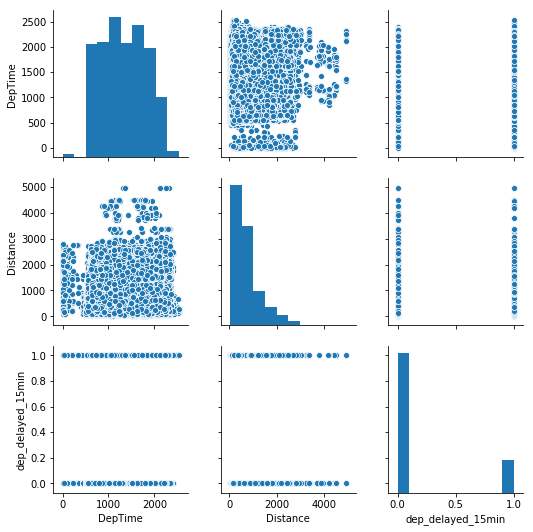

In [362]:
sns.pairplot(train_df_fd);

In [122]:
columns_enc_1 = ['Month', 'DayofMonth', 'DayOfWeek']
columns_enc_2 = ['UniqueCarrier']

In [363]:
train_df_fd_enc = pd.get_dummies(train_df_fd, columns=columns_enc_1)
corr = train_df_fd_enc.drop('dep_delayed_15min', axis=1).corrwith(
                    train_df_fd['dep_delayed_15min'], 
                    axis=0, drop=False, method='pearson'
                    )
corr.sort_values(ascending=False)[:6]

DepTime            0.243819
Month_c-12         0.038848
Month_c-7          0.037493
DayOfWeek_c-5      0.035553
Month_c-6          0.024279
DayofMonth_c-22    0.023056
dtype: float64

In [364]:
train_df_fd_enc = pd.get_dummies(train_df_fd, columns=columns_enc_2)
corr = train_df_fd_enc.drop('dep_delayed_15min', axis=1).corrwith(
                    train_df_fd['dep_delayed_15min'], 
                    axis=0, drop=False, method='pearson'
                    )
corr.sort_values(ascending=False)[:6]

DepTime             0.243819
UniqueCarrier_EV    0.043721
UniqueCarrier_WN    0.024679
UniqueCarrier_FL    0.023331
UniqueCarrier_AS    0.020361
UniqueCarrier_YV    0.012837
dtype: float64

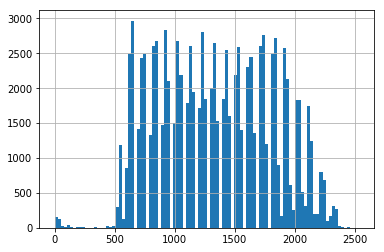

In [181]:
# Посмотрим на распределение времени отправления
train_df_fd['DepTime'].hist( bins=100);

In [37]:
train_df_fd.DayofMonth.replace(['c-%d' % i for i in range(1, 10)], 
                               ['c-0%d' % i for i in range(1, 10)], inplace=True)

In [40]:
dayssorted = train_df_fd.DayofMonth.value_counts().index.sort_values()

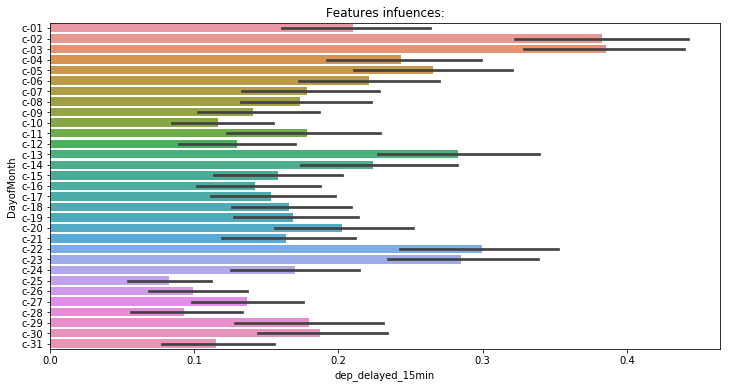

In [41]:
# Проверим опоздания по дням в декабре

plt.figure(figsize=(12, 6));
sns.barplot(x="dep_delayed_15min", y="DayofMonth", data=train_df_fd[train_df_fd.Month == 'c-1'],
           order=dayssorted);
plt.title('Features infuences:');

In [332]:
train_df_fd['dep_delayed_15min'][(train_df_fd['Month'] == 'c-12')].value_counts()

0    6271
1    1994
Name: dep_delayed_15min, dtype: int64

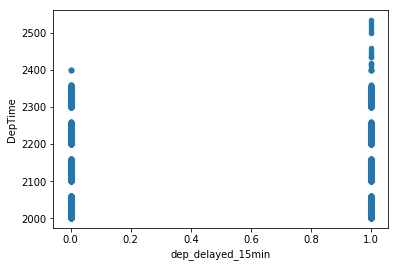

In [428]:
# Посмотрим на распределение метки в зависимости от времени отправления 
train_df_fd[train_df_fd.DepTime > 2000].plot("dep_delayed_15min", 'DepTime', kind="scatter");

Видно, что после 2400 не случаются опоздания.

Далее посмотрим на то, при каких значениях DepTime происходит наибольшее количество опозданий.

In [370]:
train_df_fd.DepTime[train_df_fd["dep_delayed_15min"] == 1]. \
    value_counts().sort_values(ascending=False)[:25]


1800    58
1830    57
1920    57
1725    56
1805    55
2030    55
1755    52
1730    51
2100    50
1815    50
2005    49
2130    49
1935    48
1910    47
1900    46
1650    45
1930    45
2125    45
1610    45
1750    45
1955    44
1945    44
1810    44
1740    43
1540    43
Name: DepTime, dtype: int64

На основе полученной информации добавим признак, основанных на DepTime: 
<center>DepTime > 1530

In [18]:
train_df_fd['DepTime > 1530'] = train_df_fd['DepTime'].apply(lambda x: 0 if x < 1530 else 1)
test_df_fd['DepTime > 1530'] = test_df_fd['DepTime'].apply(lambda x: 0 if x < 1530 else 1)
# train_df_fd['DepTime > 2400'] = train_df_fd['DepTime'].apply(lambda x: 0 if x < 2400 else 1)
# test_df_fd['DepTime > 2400'] = test_df_fd['DepTime'].apply(lambda x: 0 if x < 2400 else 1)
train_df_fd['Distance > 1000'] = train_df_fd['Distance'].apply(lambda x: 0 if x < 1000 else 1)
test_df_fd['Distance > 1000'] = test_df_fd['Distance'].apply(lambda x: 0 if x < 1000 else 1)

In [19]:
# Добавим еще признаков
train_df_fd['DepTimeLog'] = train_df_fd['DepTime'].apply(lambda x: np.log(x))
test_df_fd['DepTimeLog'] = test_df_fd['DepTime'].apply(lambda x: np.log(x))

# train_df_fd['Distancelog'] = train_df_fd['Distance'].apply(lambda x: x**2)
# test_df_fd['Distancelog'] = test_df_fd['Distance'].apply(lambda x: x**2)


# train_df_fd['DepTimesq'] = train_df_fd['DepTime'].apply(lambda x: x**2)
# test_df_fd['DepTimeLsq'] = test_df_fd['DepTime'].apply(lambda x: x**2)

# train_df_fd['DepTimepairs'] = train_df_fd['DepTime'] * np.append(train_df_fd['DepTime'][1:].values, 1)
# test_df_fd['DepTimepairs'] = test_df_fd['DepTime'] * np.append(test_df_fd['DepTime'][1:].values, 1)

train_df_fd['DoW+M'] = ((test_df_fd.DayofMonth == 'c-21') 
    & ((test_df_fd.Month == 'c-12'))).astype(int)

In [20]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(train_df_fd.drop('dep_delayed_15min', axis=1), y_train, 
                                                                test_size=0.3, 
                                                                random_state=17)

In [564]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': 17
         }
all_train_data = Pool(data=train_df_fd.drop('dep_delayed_15min', axis=1),
                      label=y_train,
                      cat_features=categ_feat_idx
                     )
scores = cv(pool=all_train_data,
            params=params, 
            fold_count=4,
            seed=17, 
            shuffle=True,
            stratified=True, # if True the folds are made by preserving the percentage of samples for each class
            plot=True
           )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6713343	best: 0.6713343 (0)	total: 1.14s	remaining: 18m 56s
200:	test: 0.7425293	best: 0.7425293 (200)	total: 4m 6s	remaining: 16m 17s
400:	test: 0.7491332	best: 0.7491332 (400)	total: 8m 14s	remaining: 12m 19s
600:	test: 0.7540087	best: 0.7540087 (600)	total: 13m	remaining: 8m 37s
800:	test: 0.7563143	best: 0.7563143 (800)	total: 17m 52s	remaining: 4m 26s
999:	test: 0.7574234	best: 0.7574234 (999)	total: 22m 42s	remaining: 0us


In [21]:
# %%time
ctb = CatBoostClassifier(random_seed=17, eval_metric = 'AUC')
ctb.fit(X_train_part, y_train_part,
        eval_set=(X_valid, y_valid),
        cat_features=categ_feat_idx,
        early_stopping_rounds = 200,
        verbose = 200,
        use_best_model=True,
        plot=False
       );

Learning rate set to 0.121895
0:	test: 0.6261918	best: 0.6261918 (0)	total: 265ms	remaining: 4m 24s
200:	test: 0.7491208	best: 0.7491304 (199)	total: 26.6s	remaining: 1m 45s
400:	test: 0.7527316	best: 0.7527316 (400)	total: 56s	remaining: 1m 23s
600:	test: 0.7554900	best: 0.7556527 (582)	total: 1m 24s	remaining: 55.9s
800:	test: 0.7564197	best: 0.7566215 (692)	total: 1m 52s	remaining: 27.9s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.756621529
bestIteration = 692

Shrink model to first 693 iterations.


In [535]:
# %%time
ctb = CatBoostClassifier(random_seed=17, eval_metric = 'AUC')
ctb.fit(X_train_part, y_train_part,
        eval_set=(X_valid, y_valid),
        cat_features=categ_feat_idx,
        early_stopping_rounds = 200,
        verbose = 200,
        use_best_model=True,
        plot=True
       );

Learning rate set to 0.121895


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6252466	best: 0.6252466 (0)	total: 209ms	remaining: 3m 28s
200:	test: 0.7512919	best: 0.7512919 (200)	total: 26.6s	remaining: 1m 45s
400:	test: 0.7567838	best: 0.7567838 (400)	total: 54.5s	remaining: 1m 21s
600:	test: 0.7585049	best: 0.7586979 (591)	total: 1m 25s	remaining: 56.9s
800:	test: 0.7614012	best: 0.7614053 (773)	total: 1m 55s	remaining: 28.7s
999:	test: 0.7626153	best: 0.7627110 (987)	total: 2m 24s	remaining: 0us

bestTest = 0.7627109788
bestIteration = 987

Shrink model to first 988 iterations.


In [471]:
# %%time
ctb = CatBoostClassifier(random_seed=17, eval_metric = 'AUC', 
                         iterations=1200
                        )
ctb.fit(train_df_fd.drop('dep_delayed_15min', axis=1), y_train,
        cat_features=categ_feat_idx,
        early_stopping_rounds = 200,
        verbose = 200,
       );

Learning rate set to 0.052429
0:	total: 132ms	remaining: 2m 38s
200:	total: 27.8s	remaining: 2m 18s
400:	total: 57.4s	remaining: 1m 54s
600:	total: 1m 29s	remaining: 1m 29s
800:	total: 2m	remaining: 60s
1000:	total: 2m 30s	remaining: 30s
1199:	total: 3m 1s	remaining: 0us


In [472]:
ctb_test_pred2 = ctb.predict_proba(test_df_fd)[:, 1]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sample_sub = pd.read_csv('sample_submission.csv', 
                             index_col='id')
    sample_sub['dep_delayed_15min'] = ctb_test_pred2
    sample_sub.to_csv('ctb_pred2.csv')

In [534]:
train_df_fd.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,flight,DepTime > 1530,Distance > 1000,DepTimeLog
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,0,ATL-->DFW,1,0,7.567346
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,0,PIT-->MCO,1,0,7.344719
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,0,RDU-->CLE,0,0,7.259820
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,0,DEN-->MEM,0,0,6.922644
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,1,MDW-->OMA,1,0,7.510978


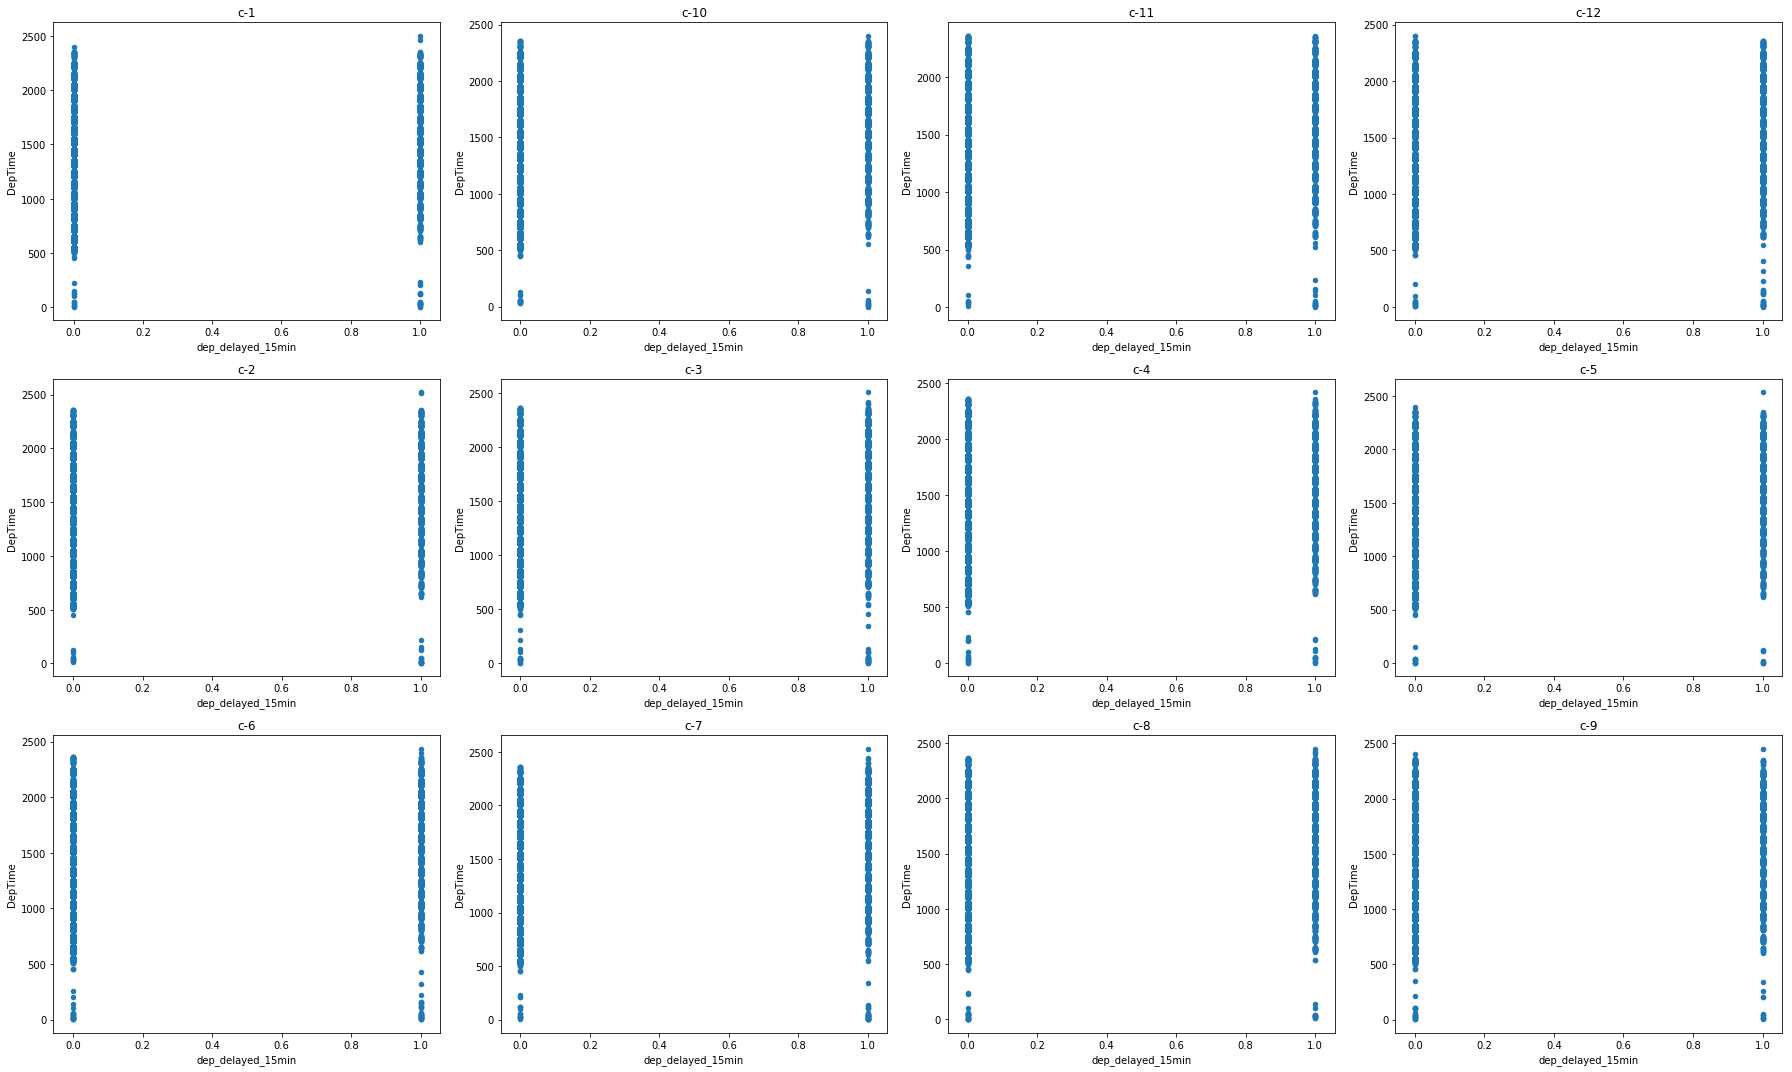

In [538]:
# Посмотрим на завимимость целевой метки от DepTime в зависимости от месяца

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, m in enumerate(np.unique(train_df_fd.Month)):
    train_df_fd[train_df_fd.Month == m].plot(
        "dep_delayed_15min", 'DepTime', subplots=True, kind="scatter",
        ax=axes[idx // 4, idx % 4]
                                            );
    axes[idx // 4, idx % 4].set_title(m)
    plt.tight_layout()

In [32]:
['c-%d' % i for i in range(1, 11)]

['c-1', 'c-2', 'c-3', 'c-4', 'c-5', 'c-6', 'c-7', 'c-8', 'c-9', 'c-10']